## Definitions

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from main import simulate_apartment_stock, generate_interventions, simulate_social_housing, calculate_costs
from analysis import * 
import copy

idx = pd.IndexSlice

# Model systému podpory v bydlení
- TODO Základní představení modelu

## Nabídka - byty v systému

* Nabídka simuluje počet bytů v systému, které budou k dispozici pro domácnosti v bytové nouzi. Model simuluje zvlášť byty ze soukromého sektoru a byty, které jsou ve správě místních samospráv
* Nastavení modelu vede k  (téměř) lineárnímu vkladu bytů do systému. Defaultní nastavení vede k tempu 5000 soukromých a pomalu rostoucích cca 3500 - 4000 městských bytů v systému ročně.

### Garantované byty
* Nabídka garantovaných bytů závisí primárně na konkurenceschopnosti podmínek pro pronajímatale a úspěšnosti komunikace
* Jejich počet proto je modelován jediným parametrem: `guaranteed_yearly_apartments`.
* Z komunikace s Romanem Matouškem proto vzešel návrh zvažovat tři scénáře: 
    - *Konzervativní* - 2 500 bytů ročně, tj. 10 bytů na ORP, tedy méně než 1 byt na ORP za měsíc
    - *Střední* - 5 000 bytů ročně
    - *Rozsáhlý* - 10 000 bytů ročně
* Pokud není řečeno jinak je použit *střední scénář* 

### Obecní byty
* Již dnes existuje cca 200 000 bytů - `municipal_apartments_today`
* Z již existujících bytů se každoročně 1,5 % uvolní do systému sociálního bydlení - `municipal_existing_availability_rate`
* I v budoucnu budou stavět nové městské byty - konzervativně předpokládáme 1000 bytů ročně - `municipal_yearly_new_apartments`
* Z nových bytů předpokládáme, že by do systému výrazně větší část - klidně 50 % - `municipal_new_availability_rate`

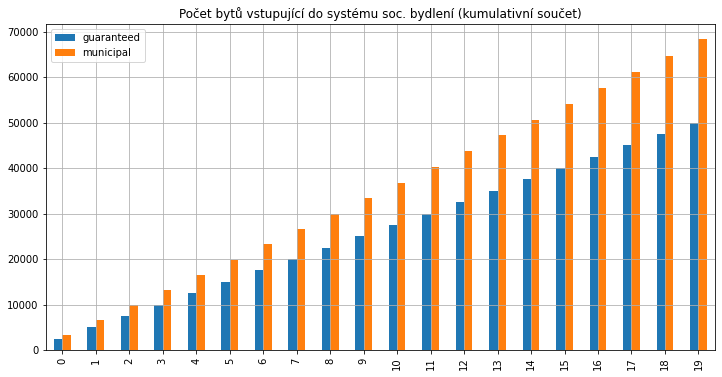

In [2]:
apartments = simulate_apartment_stock(
    guaranteed_yearly_apartments=2500,
    municipal_apartments_today=200000,
    municipal_yearly_new_apartments=1000,
    municipal_existing_availability_rate=.015,
    municipal_new_availability_rate=.3,
    years=np.arange(20)
)
apartments.plot.bar(grid=True,figsize=(12,6),title='Počet bytů vstupující do systému soc. bydlení (kumulativní součet)');

## Poptávka - lidé v bytové nouzi

* Také poptávka je modelována 2 druhy domácností
* Model prefenčně umísťuje *méně rizikové* domácnosti do *garantovaných* bytů a *rizikové* domácnosti do *obecních* bytů 
* Oba druhy domácností mají v čase lineární trend

* Celkově je 50 000 domácností v bytové nouzi - z toho 65 % domácností jsou  *méně rizikové* domácnosti a  35 % *rizikové* domácnosti
* Předpokládáme každoroční přísun dalších 5 000 domácností - z toho 65 % domácností jsou  *méně rizikové* domácnosti a  35 % *rizikové* domácnosti

In [3]:
hhs_inflow = pd.Series({
    ('low','current_level'):.65 * 50000,
    ('low','yearly_growth'):.65 * 5000,
    ('high','current_level'):.35 * 50000,
    ('high','yearly_growth'):.35 * 5000,
}).unstack(1)
hhs_inflow

,current_level,yearly_growth
high,17500.0,1750.0
low,32500.0,3250.0


## Intervence a průchod domácnosti systémem
### "Měkké" intervence
* Pokud se domácnost dostane do BN, zařazuje se do tzv. fronty (`queue`).
* Domácnosti ve frontě postupně dostávají intervence:
    1. `self-help` - některé domácnosti si zvládnou pomoci samy a dostanou se ven z BN
    2. `consulting` - další část domácností přijde pro poradenství na KMB a díky tomu se zvládnou dostat ven z BN
    3. `mop_payment` - další část domácností po konzultaci na KMB dostane vyplacenou dávku MOP
* V následující tabulce je uveden podíl domácností ve froně, kterým se dostane této podpory
* Je třeba si uvědomit, že uvedené podíly se aplikují postupně a tedy postupně ubývá základ vůči kterému se podíly aplikují

In [4]:
intervention_shares = pd.Series({
    ('low','self_help'):.2,
    ('low','consulting'):.1,
    ('low','mop_payment'):.1,
    ('high','self_help'):.05,
    ('high','consulting'):.05,
    ('high','mop_payment'):.15
}).unstack()
intervention_shares

,consulting,mop_payment,self_help
high,0.05,0.15,0.05
low,0.10,0.10,0.20


### Umístění do bytů
* Domácnosti, které nezískají žádnou z "měkkých" intervencí se pokusíme umístit do bytů
* Také zde probíhá konzultace s KMB - je třeba počítat s náklady
* Po umístění do bytů probíhá sociální práce - Asistence v bydlení - je třeba počítat s náklady
* Umístění do bytů probíhá dvou-fázově: 
    1. Primární umístění:
        a. Méně rizikové domácnosti -> garantované bydlení
        b. Rizikové domácnosti -> obecní byty
    2. Sekundární umístění:
        a. Rizikové domácnosti -> garantované bydlení
        b. Méně rizikové domácnosti -> obecní byty
* Vždy jsou umístěny všechny domácnosti do všech aktuálně dostupných bytů

### Délka intervence

* Každá intervence má jinou dobu trvání
* Zatímco měkké intervence jsou jednorázové a z pohledu modelu trvají jeden rok, bydlení trvá déle

In [9]:
years_of_support = pd.Series({
    'municipal':5,
    'guaranteed':2,
    'self_help':1,
    'mop_payment':1,
    'consulting':1
})
years_of_support

municipal      5
guaranteed     2
self_help      1
mop_payment    1
consulting     1
dtype: int64

### Relaps - neúspěšné intervence

* část domácností, se i přes to, že dostanou intervenci, se po čase zase vrátí do problémů
* Tomu model říká "relaps" - po konci intervenci domácnost neopouští systém, ale vrací se zpátky do fronty
* Tabulka níže ukazuje, jaká část domácností, které dostaly danou intervenci se po konci intervence vrací zpět do systému

In [5]:
relapse_rates = pd.Series({
    ('low','self_help'):.8,
    ('low','consulting'):.6,
    ('low','mop_payment'):.4,
    ('low','guaranteed'):.2,
    ('low','municipal'):.2,
    ('high','self_help'):.7,
    ('high','consulting'):.5,
    ('high','mop_payment'):.3,
    ('high','guaranteed'):.1,
    ('high','municipal'):.1
}).unstack()

relapse_rates

,consulting,guaranteed,mop_payment,municipal,self_help
high,0.5,0.1,0.3,0.1,0.7
low,0.6,0.2,0.4,0.2,0.8


### Náklady intervencí

* Rozlišujeme tři druhy nákladů:
    * **Fixní** - náklady existence systému sociálního bydlení, zcela nezávislé na výkonu - např. IT systém. V modelu nejsou žádným způsobem zohledněny.
    * **Vstupní** - náklady provedení intervence - například sehnání bytu do systému či vyplacení MOP
    * **Průběžné/Roční** - náklady existující intervence - náklady bytu


In [6]:
intervention_costs = pd.Series({
    ('entry','self_help'):0,
    ('entry','consulting'):5000,
    ('entry','mop_payment'):15000,
    ('entry','guaranteed'):5000,
    ('entry','municipal'):5000,
    ('entry', 'social_assistance'): 0,
    ('yearly','self_help'):0,
    ('yearly','consulting'):0,
    ('yearly','mop_payment'):0,
    ('yearly','guaranteed'):25000,
    ('yearly','municipal'):25000,
    ('yearly', 'social_assistance'): 30000
}).unstack()
intervention_costs

,consulting,guaranteed,mop_payment,municipal,self_help,social_assistance
entry,5000,5000,15000,5000,0,0
yearly,0,25000,0,25000,0,30000


### Estimace modelu

In [10]:
DEFAULT_PARAMS = {
    'years':np.arange(20),
    'years_of_support':years_of_support,
    'intervention_costs':intervention_costs,
    'guaranteed_yearly_apartments':2500, # Konzervativní odhad 2500 - 1 byt na měsíc pro každé ORP; Divoký odhad 10 000 bytl,
    'municipal_apartments_today': 200000,
    'municipal_yearly_new_apartments': 1000,
    'municipal_existing_availability_rate': .015,
    'municipal_new_availability_rate': .3,
    'relapse_rates':relapse_rates,
    'intervention_shares':intervention_shares,
    'hhs_inflow':hhs_inflow
}

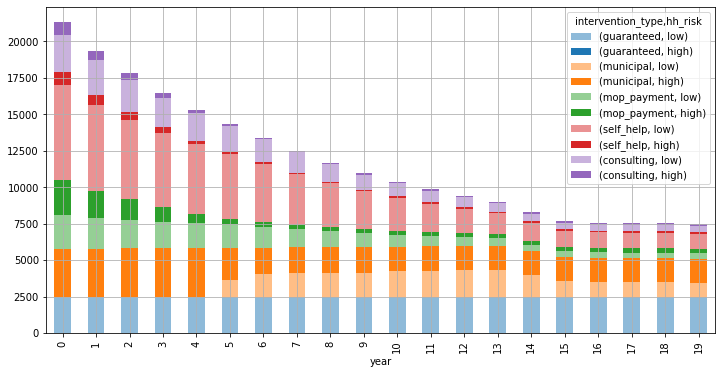

In [11]:
from main import simulate_social_housing

interventions, hhs, returnees, costs = simulate_social_housing(**DEFAULT_PARAMS)

plot_basic_interventions(interventions);

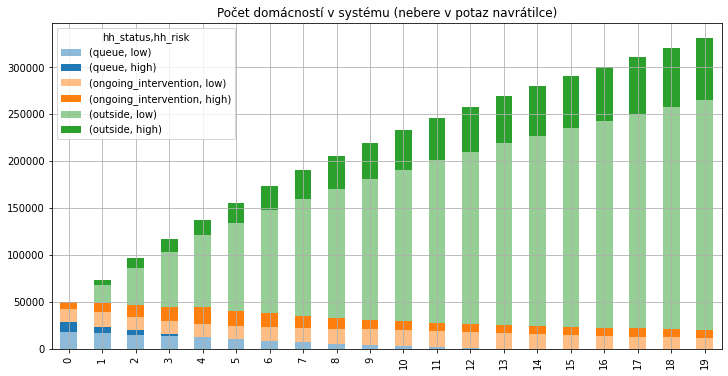

In [12]:
plot_basic_hhs(hhs);

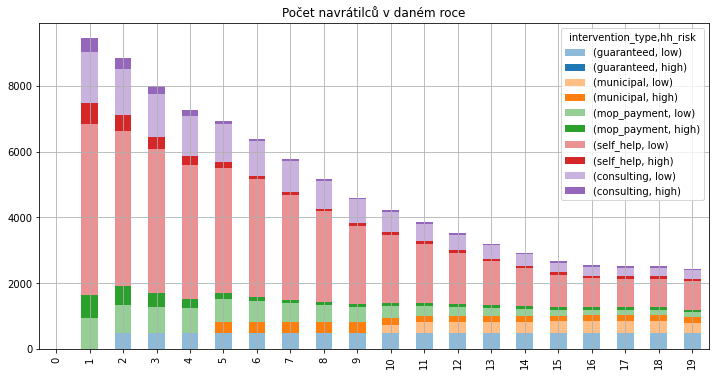

In [13]:
plot_basic_returnees(returnees);

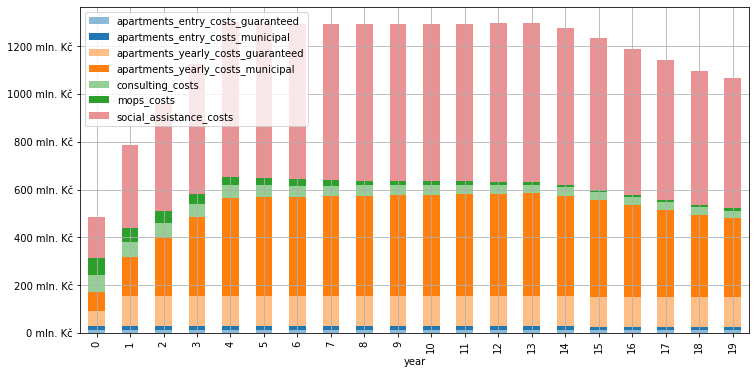

In [14]:
plot_basic_costs(costs);

## Porovnávání alternativ

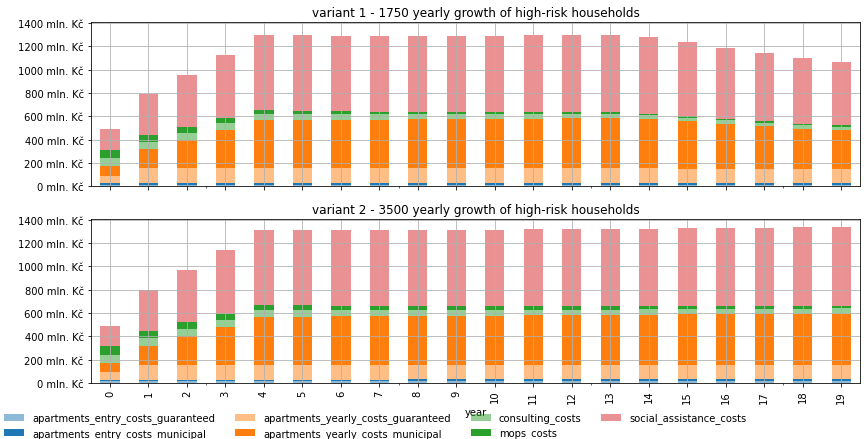

In [44]:
params_2 = copy.deepcopy(DEFAULT_PARAMS)

params_2['hhs_inflow'].loc['high','yearly_growth'] = DEFAULT_PARAMS['hhs_inflow'].loc['high','yearly_growth'] * 2

fig, axs = compute_variants(
    params_1 = DEFAULT_PARAMS, 
    params_2 = params_2,
    label_1 = 'variant 1 - 1750 yearly growth of high-risk households',
    label_2 = 'variant 2 - 3500 yearly growth of high-risk households',
    plot_function='plot_basic_costs'
);